In [1]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from imp import reload
from scipy.stats import entropy
from scipy.special import factorial
%matplotlib inline

import numba

from info_measures import dataset_generators as dg
import info_measures.numpy.kraskov_stoegbauer_grassberger as ksg

In [2]:
# Load and remove zeros
mnist = input_data.read_data_sets('.', one_hot=True, validation_size=0, reshape=False)
X = mnist.train.images
X = X[:,2:-2:2,2:-2:2]

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


# Image

In [85]:
reload(dg)

dg_mnist = dg.ImageGenerator(X, grow_axis=2)

In [86]:
print(dg_mnist.X.shape)
print(dg_mnist.symmetry_axes)

(60000, 12, 12, 1)
[1, 2]


In [87]:
dim = 4
perp_dim = 7
samples = dg_mnist.sample_data(dim, perp_dim=perp_dim)

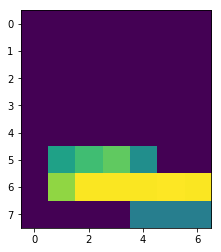

In [88]:
plt.imshow(samples[6].reshape(2*dim, perp_dim))

# VectorSpace

In [71]:
reload(dg)
dg_vec = dg.VectorSpaceGenerator(X)

In [63]:
xp = dg_vec.sample_data(grow_dim=3, n_samples_per_image=1)

(60000, 144, 1)
(60000, 6)
(60000, 6)
(60000, 6, 1)


In [72]:
%timeit dg_vec.sample_data(grow_dim=3, n_samples_per_image=2)

985 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


0.17885759204 0.348598697645
0.17811602338 0.347999003093
0.176177069003 0.346290274612
0.177172232476 0.347912727177
0.176967918699 0.34779948616
0.176921448122 0.346992617837


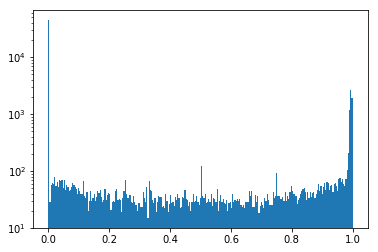

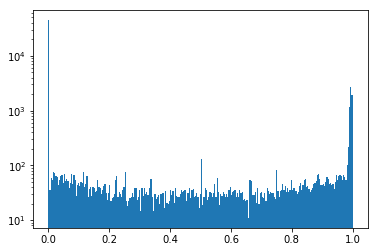

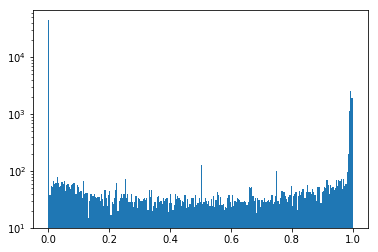

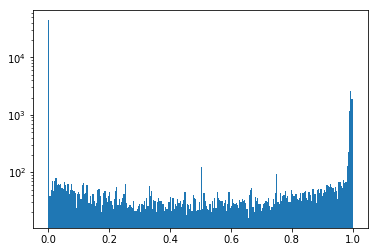

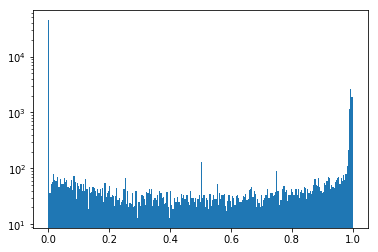

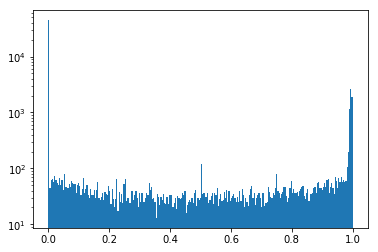

In [65]:
plt.close()
pdfs = []
for ii in range(xp.shape[1]):
    plt.figure()
    pdf, _, _ = plt.hist(xp[:, ii], bins=np.linspace(0, 1, 256))
    print(xp[:, ii].mean(), xp[:, ii].std())
    pdfs.append(pdf)
    plt.yscale('log')

In [158]:
im = np.zeros((14, 14))
im2 = np.zeros((14, 14))
for ii in range(14):
    for jj in range(ii):
        im[ii, jj] = entropy(pdfs[ii], pdfs[jj])
        im2[ii,jj] = np.dot(xp[:,ii,0]-xp[:,ii,0].mean(), xp[:,jj]-xp[:,jj].mean())

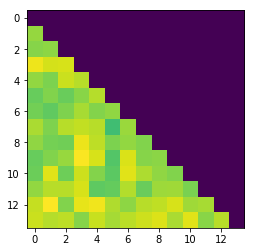

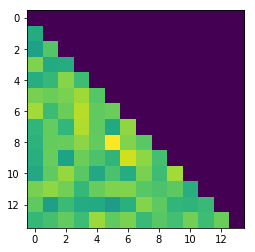

In [160]:
plt.imshow(im)
plt.figure()
plt.imshow(im2)

In [99]:
ksg_e = ksg.MutualInformation(xp[:,:3,0], xp[:,3:,0], add_noise=True)

In [100]:
ksg_e.mutual_information()

0.032866438432568756

In [97]:
ksg_e2 = ksg.MutualInformation(xp[:,0][np.random.permutation(60000)], xp[:,1], add_noise=True)

In [98]:
ksg_e2.mutual_information()

0.0032976463352465402

# MultiChannelTimeseries

In [3]:
reload(dg)

dg_time = dg.MultiChannelTimeseriesGenerator(X)

In [39]:
n_t = 6
xp = dg_time.sample_data(n_t, 1, 1)

In [40]:
xp.shape

(60000, 12, 1)

In [41]:
x0 = xp[::1000, :n_t]
x0 = x0.reshape(x0.shape[0], -1)
x1 = xp[::1000, n_t:]
x1 = x1.reshape(x0.shape[0], -1)
ksg_e = ksg.MutualInformation(x0, x1, add_noise=True)

/home/jesse/Development/info_measures/info_measures/numpy/kraskov_stoegbauer_grassberger.py:107: RuntimeWarning: invalid value encountered in true_divide
  X = X / X.std(axis=0, keepdims=True)


In [42]:
ksg_e.mutual_information()

inf

# Number of multichannel timeseries samples

In [2]:
# batch size
n_X = 1
# time steps
n_t = 500000
# channels
n_c = 128
# features
n_f = 1

# channels per sample
c = 1
# time per sample (doubled for PI)
t = 1

n_s = n_X * factorial(n_c, exact=True) // factorial(n_c-c, exact=True) * ((n_t) + 1 - 2*t)
print('{} samples'.format(n_s))
print('{} MB'.format(np.around(64 * n_f * n_s / 8 / 1024**2, 2)))

63999872 samples
488.28 MB


# Number of linear image samples

In [40]:
# batch size
n_X = 60000
# width (PI direction)
n_w = 28
# height (channels direction)
n_h = 28
# features
n_f = 1

# height (channels) per sample
H = 1
# width(time) per sample (doubled for PI)
W = 1

n_s = n_X * ((n_w) + 1 - 2*W) * ((n_h) + 1 - H)
print('{} samples'.format(n_s))
print('{} MB'.format(np.around(64 * n_f * n_s / 8 / 1024**2, 2)))

45360000 samples
346.07 MB


# Number of vectorspace samples

In [45]:
# batch size
n_X = 60000
# channels (PI direction)
n_c = 28 * 28
# features
n_f = 1

# channels (time) per sample (doubled for PI)
c = 1

n_s = n_X * factorial(n_c, exact=True) // factorial(n_c-2*c, exact=True)
print('{} samples'.format(n_s))
print('{} GB'.format(np.around(64 * n_f * n_s / 8 / 1024**3, 2)))

36832320000 samples
274.42 GB
